# Overview
This notebook loads data saved in MongoDB and saves it locally so that it can be accessed using the keras_preprocessing library. The testing set is then used to train a convolutional neural network heavily based on the [Rock Paper Scissors CNN Tutorial](https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%208%20-%20Lesson%202%20-%20Notebook%20(RockPaperScissors).ipynb#scrollTo=LWTisYLQM1aM) from TensorFlow.

# Imports (MongoDB)

In [1]:
import os
import pickle
from PIL import Image 
from skimage import io
import random
import pandas as pd
import pymongo
import numpy as np
import bson
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os, shutil, errno

# Connecting to MongoDB

In [2]:
user = ""
pswd = ""

In [3]:
client = pymongo.MongoClient("mongodb+srv://{}:{}@cluster0.x6cn9.mongodb.net/DATA_603?retryWrites=true&w=majority".format(user, pswd))
db = client["DATA_603"]
# collection = db["images"]

In [4]:
def load_test_df(collection=1):
    df_ = pd.DataFrame(db["test_{}".format(collection)].find({}))
    df_["numpy_arr"] = df_["numpy_arr"].apply(lambda x: pickle.loads(x))
    df_["numpy_arr"] = df_["numpy_arr"].apply(lambda x: Image.fromarray(x, 'RGB'))
    
    return df_
    
def load_df():
    arr = []
    for i in range(56):
        try:
            temp = pd.DataFrame(db["images_{}".format(i)].find({}))
            temp["numpy_arr"] = temp["numpy_arr"].apply(lambda x: pickle.loads(x))
            temp["numpy_arr"] = temp["numpy_arr"].apply(lambda x: Image.fromarray(x, 'RGB'))    
            arr.append(temp)
        except:
            # display(temp)
            continue

        if i % 5 == 0 and i < 50:
            print("{}%".format(2*i), end ="... ")
        if i == 50:
            print("Finished Loading")

    df = pd.concat(arr, ignore_index=True)
    return df    
    
df = load_df()

0%... 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... Finished Loading


In [5]:
df = df[df["hand_labled_target"].notna()]
df

,_id,source_url,numpy_arr,target,hand_labled_target
0,Extra_0,https://image.shutterstock.com/image-photo/smi...,<PIL.Image.Image image mode=RGB size=150x150 a...,No Mask,No Mask
1,Extra_1,https://image.shutterstock.com/image-photo/you...,<PIL.Image.Image image mode=RGB size=150x150 a...,No Mask,No Mask
2,Extra_2,https://image.shutterstock.com/image-photo/smi...,<PIL.Image.Image image mode=RGB size=150x150 a...,No Mask,No Mask
3,Extra_3,https://image.shutterstock.com/image-photo/mus...,<PIL.Image.Image image mode=RGB size=150x150 a...,No Mask,No Mask
4,Extra_4,https://image.shutterstock.com/image-photo/fin...,<PIL.Image.Image image mode=RGB size=150x150 a...,No Mask,No Mask
...,...,...,...,...,...
1237,Mask_610,https://image.shutterstock.com/image-photo/chi...,<PIL.Image.Image image mode=RGB size=150x150 a...,Mask,Mask
1238,Mask_611,https://image.shutterstock.com/image-photo/wom...,<PIL.Image.Image image mode=RGB size=150x150 a...,Mask,Mask
1239,Mask_612,https://image.shutterstock.com/image-photo/clo...,<PIL.Image.Image image mode=RGB size=150x150 a...,Mask,No Mask
1240,Mask_613,https://image.shutterstock.com/image-photo/che...,<PIL.Image.Image image mode=RGB size=150x150 a...,Mask,No Mask


# Saving PIL.Image files as png into a directory

Create folders first

In [6]:
base_dir = "CNN_Images"
folders = ["Train", "Test"]
categories  =  ["Mask", "No_Mask"]

try:
    # os.mkdir(base_dir)
    os.mkdir(os.path.join(os.getcwd(), base_dir))
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

# Create folders for train, test, and validation
for folder in folders:
    try:
        os.mkdir(os.path.join(os.getcwd(), base_dir, folder))
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
    pass

    # Within each folder, create a mask and no mask folder
    for cat in categories:
        try:
            os.mkdir(os.path.join(os.getcwd(), base_dir, folder, cat))
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise
            pass

Downloading images into respective directories

In [7]:
test_size = .2
random.seed(2020)
img_format = "png"
#target = "target"
target = "hand_labled_target"

for index, row in df.iterrows():
    #break # only run once
    if row[target]=="Mask":
        if random.random() < test_size:
            path = os.path.join(base_dir, "Test", "Mask", "{}.{}".format(row["_id"], img_format))
        else:
            path = os.path.join(base_dir, "Train", "Mask", "{}.{}".format(row["_id"], img_format))
        row["numpy_arr"].save(path)
        
    elif row[target]=="No Mask":
        if random.random() < test_size:
            path = os.path.join(base_dir, "Test", "No_Mask", "{}.{}".format(row["_id"], img_format))
        else:
            path = os.path.join(base_dir, "Train", "No_Mask", "{}.{}".format(row["_id"], img_format))
        row["numpy_arr"].save(path)

# Read, Images are labeled based on directory

In [8]:
from keras_preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        #'train',
        os.path.join(base_dir, "Train"),
        target_size=(150, 150),
        class_mode='binary')
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        #'test',
        os.path.join(base_dir, "Test"),
        target_size=(150, 150),
        class_mode='binary')

Found 1018 images belonging to 2 classes.
Found 224 images belonging to 2 classes.


# Start by copying architecture from [Rock Paper Scissors](https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%208%20-%20Lesson%202%20-%20Notebook%20(RockPaperScissors).ipynb#scrollTo=LWTisYLQM1aM)

## ~83% Accuracy on Testing Data
- test_aze = .2
- Number of Images = 726 and 1242
- optimizer = 'adam'
- epochs = 25
- target = "hand_labled_target"
- [Rock Paper Scissors CNN Architecture](https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%208%20-%20Lesson%202%20-%20Notebook%20(RockPaperScissors).ipynb#scrollTo=LWTisYLQM1aM)

## Helpful things learned so far:
Understanding the difference between Binary and Categorical output.
> - When reading in data from directory, had to make sure I was using class_mode='binary' and not class_mode='categorical' <br>
> - When doing Binary Classification, the activation function should be a sigmoid function, and not a softmax <br>
> - [Reference from Stack OverFlow](https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible)
## What to do next:
Need to better understand, and explain the architecture of a neural network
- [ ] Filters
    - [ ] What they are
    - [ ] How they can help here
- [ ] Pooling
    - [ ] What they are
    - [ ] How they can help here
- [ ] Number of layers
- [ ] Number of nodes in layers
- [ ] Should activation functions be constant from layer to layer?
- [ ] Understand First layer Conv2D(64, (3,3) ,..., ...)

In [9]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(2**8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [10]:
%%time 
history = model.fit(train_generator, 
                    epochs=25,
                    validation_data = test_generator)

Epoch 1/25
32/32 [==============================] - 120s 4s/step - loss: 0.6677 - accuracy: 0.6582 - val_loss: 0.6254 - val_accuracy: 0.7009
Epoch 2/25
32/32 [==============================] - 127s 4s/step - loss: 0.6125 - accuracy: 0.6690 - val_loss: 0.5978 - val_accuracy: 0.7143
Epoch 3/25
32/32 [==============================] - 114s 4s/step - loss: 0.5882 - accuracy: 0.6729 - val_loss: 0.5207 - val_accuracy: 0.7277
Epoch 4/25
32/32 [==============================] - 92s 3s/step - loss: 0.5397 - accuracy: 0.7102 - val_loss: 0.4844 - val_accuracy: 0.7679
Epoch 5/25
32/32 [==============================] - 89s 3s/step - loss: 0.5244 - accuracy: 0.7466 - val_loss: 0.4904 - val_accuracy: 0.7098
Epoch 6/25
32/32 [==============================] - 83s 3s/step - loss: 0.5051 - accuracy: 0.7613 - val_loss: 0.4914 - val_accuracy: 0.7188
Epoch 7/25
32/32 [==============================] - 83s 3s/step - loss: 0.4681 - accuracy: 0.7701 - val_loss: 0.4247 - val_accuracy: 0.7768
Epoch 8/25
32/32 

In [11]:
from statistics import mean

print("training max", max((history.history['accuracy'][14:])))
print("testing mean", mean((history.history['val_accuracy'])))

training max 0.9803536534309387
testing mean 0.8148214364051819


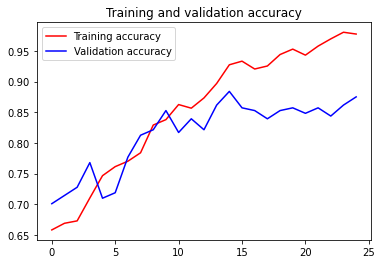

In [12]:
import matplotlib.pyplot as plt

num_epochs = range(len(history.history['accuracy']))

plt.plot(num_epochs, history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(num_epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)

plt.show()

# Save Model 

In [14]:
# model.save("Mask_vs_No_Mask_hand_labled_target.h5")
model.save(os.path.join("Models", "ModelMask_vs_No_Mask_{}.h5".format(target)))